In [2664]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

inv = np.linalg.inv

In [2665]:
!ls ios

IneritalDataAcquisition
bias-rectification-old.csv
bias-rectification.csv
bike-around-block-with-acceleration-facing-in.csv
bike-around-block-with-acceleration.csv
bike-around-block.csv
bike-around-parking-lot.csv
my_iOS_device 200216 20_47_14.csv
rotation-along-principle-axes.csv
rotation-along-principle-axes_old.csv
rotation-through-g-field.csv
shake-north-and-east.csv
shake-with-gps-old.csv
shake-with-gps.csv
sideways-shake.csv
sit-on-couch.csv
slow-rotation.csv
train-ride.csv
walk-around-block.csv
walk-around-mva.csv
z-bias-balance.csv


In [3099]:
filename = 'ios/rotation-through-g-field.csv'
fields = pd.read_csv('ios/shake-with-gps.csv').columns
filename = 'ios/walk-around-block.csv'
filename = 'ios/bike-around-block.csv'
#filename = 'ios/bike-around-block-with-acceleration.csv'
#filename = 'ios/bike-around-block-with-acceleration-facing-in.csv'
#filename = 'ios/bike-around-parking-lot.csv'
#filename = 'ios/sideways-shake.csv'
#filename = 'ios/z-bias-balance.csv'
(t, _, _,location_timestamp,
latitude, longitude, altitude,
 _, _, vertical_accuracy, horizontal_accuracy, _, 
at, ax, ay, az,
gt, gx, gy, gz,
_, magx, magy, magz,
_, _, alt, _,
) = pd.read_csv(filename)[fields].values.T[:,::5] #[:,int(0e2):int(840e2):30]

In [3100]:
ax

array([0.0059967041015625, 0.005645751953125, 0.006317138671875, ...,
       0.0403900146484375, 0.034454345703125, 0.0484619140625],
      dtype=object)

In [3101]:
t = pd.to_datetime(t)
t[-1] - t[0]

Timedelta('0 days 00:05:16.267000')

In [3102]:
gzb

-0.0055

In [3103]:
np.median(gz)

-0.001288171042688191

In [3181]:
azb = -.0085
azb = .033
axb = -.001
ayb = -.002

gzb = -0.0055
gyb = 0# -0.0097045
gxb = 0#-0.012817940597675125

In [3182]:
 np.mean((az)) - azb

-1.0417822488572996

In [3183]:
dt = ((t[-1] - t[0]) / (len(t) - 1)).value / 1e9

In [3184]:
def R_(yaw, pitch, roll):
    """http://planning.cs.uiuc.edu/node102.html"""
    """Performs first roll, then pitch, then yaw"""
    """a : alpha, yaw"""
    """b: beta, pitch"""
    """r: gamma, roll"""
    ca = np.cos(yaw)
    cb = np.cos(pitch)
    cg = np.cos(roll)
    sa = np.sin(yaw)
    sb = np.sin(pitch)
    sg = np.sin(roll)
    
    
    yR = np.array([
        [ca, sa, 0],
        [-sa, ca, 0],
        [0, 0, 1]
    ])
    
    pR = np.array([
        [1, 0, 0],
        [0, cb, sb],
        [0, -sb, cb]
    ])
    
    rR = np.array([
        [cg, 0, -sg],
        [0, 1, 0],
        [sg, 0, cg]
    ])
    
    #return rR @ pR @ yR
    return np.array([
        [ca*cg - sa*sb*sg, cg*sa + ca*sb*sg, -cb*sg],
        [-cb*sa, ca*cb, sb],
        [cg*sa*sb + ca*sg, -ca*cg*sb + sa*sg, cb*cg]
    ])

def get_yaw_pitch_roll_from_R(R):
    """https://math.stackexchange.com/a/2802520"""
    yaw = np.angle(-1j*R[1,0] + R[1,1])
    pitch = np.arcsin(R[1,2])
    roll = np.arctan(-R[0,2]/R[2,2])
    
    return yaw, pitch, roll

def h(mu):
    pitch, roll = mu
    return R_(0, pitch, roll) @ np.array([0, 0, -1])

In [3185]:
get_yaw_pitch_roll_from_R(R_(-1, -.2, -.5))

(-1.0, -0.2, -0.5)

In [3186]:
def new_GPS(time_index):
    lat, lng, alt = (
        np.stack([latitude, longitude, altitude]).T[time_index]
    )
    earth_radius = 6.3781e6 # meter
    dy = np.radians(lat - latitude[0]) *  earth_radius
    dx = np.radians(lng - longitude[0]) * earth_radius * np.cos(np.radians(latitude[0]))
    if time_index == 0:
        return dx, dy, alt
    elif location_timestamp[time_index] == location_timestamp[time_index-1]:
        return None
    else:
        return dx, dy, alt

In [3218]:
Q_acc = 1
Q_ang = .2

number_of_timesteps = len(t)
number_of_states = 9

inertial_accels = np.empty((number_of_timesteps, 3)) * np.nan

Q = np.array([
    [(Q_ang*dt)**2*50, 0, 0,  0,0,0, 0,0,0],  
    [0, (Q_ang*dt)**2, 0,  0,0,0, 0,0,0],   
    [0, 0, (Q_ang*dt)**2,  0,0,0, 0,0,0],
    
    [0,0,0,  0,0,0, 0,0,0],
    [0,0,0,  0,0,0, 0,0,0],
    [0,0,0,  0,0,0, 0,0,0],
    
    [0,0,0,  0,0,0, (Q_acc*dt)**2,0,0],
    [0,0,0,  0,0,0, 0,(Q_acc*dt)**2,0],
    [0,0,0,  0,0,0, 0,0,(Q_acc*dt)**2],
])    

kalman_states = np.empty((number_of_timesteps, number_of_states)) * np.nan
kalman_errors = np.empty((number_of_timesteps, number_of_states)) * np.nan

I = np.identity(number_of_states)
last_gps_time_index = 0

# initialize state
# mu :
# [yaw, pitch, roll, rx, ry, rz, vx, vy, vz]
mu = np.array([-.2 - np.pi*1, 0, 0, 0, 0, 0, 0,0,0])
P = np.array([
    [np.pi*2, 0, 0,  0, 0, 0,  0, 0, 0],
    [0, np.pi/40, 0,  0, 0, 0,  0, 0, 0],
    [0, 0, np.pi/40,  0, 0, 0,  0, 0, 0],    
    [0, 0, 0,  100, 0, 0,  0, 0, 0],    
    [0, 0, 0,  0, 100, 0,  0, 0, 0],
    [0, 0, 0,  0, 0, 100,  0, 0, 0],
    [0, 0, 0,  0, 0, 0,  .1, 0, 0],
    [0, 0, 0,  0, 0, 0,  0, .1, 0],
    [0, 0, 0,  0, 0, 0,  0, 0, .1],
])**2

g = 9.81

for time_index in range(number_of_timesteps):
    # Kalman step


    ax_, ay_, az_ = np.stack([ax, ay, az]).T[time_index, :]
    
    def f(mu, u):
        gx, gy, gz, ax_, ay_, az_ = u
        dyaw = (gz - gzb) * dt 
        dpitch = gx * dt 
        droll = gy * dt 
        
        yaw, pitch, roll, rx, ry, rz, vx, vy, vz = mu
        #total_R = R_(dyaw, dpitch, droll) @ R_(yaw, pitch, roll) 
        #yaw, pitch, roll = get_yaw_pitch_roll_from_R(total_R)
        yaw += dyaw * dt
        
        ca = np.cos(yaw)
        sa = np.sin(yaw)
        #average_R =  R_(yaw, pitch, roll)        
        average_R = np.array([
            [ca, -sa, 0],
            [sa, ca, 0],
            [0, 0, 1]
        ])
        
        accels = (
            average_R.T @
            np.array([ax_ - axb, ay_ - ayb, az_ - azb])
            + np.array([0, 0, 1]))
        #inertial_accels[time_index, :] = accels
        
        aX, aY, aZ = accels * g 
        aZ = 0
        
        rx += aX * dt ** 2 / 2 + vx * dt
        ry += aY * dt ** 2 / 2 + vy * dt
        rz += aZ * dt ** 2 / 2 + vz * dt
        
        vx += aX * dt / 2
        vy += aY * dt / 2
        vz += aZ * dt / 2
        mu = np.array([yaw, pitch, roll,
                       rx, ry, rz,
                       vx, vy, vz
                      ])
        
        return mu
    
    def h(mu):
        yaw, pitch, roll = mu[0:3]
        return R_(0, pitch, roll) @ np.array([0, 0, -1]) - np.array([axb, ayb, azb])

    yaw, pitch, roll = mu[0:3]
    ca = np.cos(yaw)
    sa = np.sin(yaw)
    cb = np.cos(pitch)
    sb = np.sin(pitch)
    sg = np.sin(roll)
    cg = np.cos(roll)
    vx, vy, vz = mu[6:9]
    
    aX, aY, aZ = np.array([ax_, ay_, az_]) * g
    aX, aY, aZ = np.array([ax_, ay_, 0]) * g    
    
    daxda = ((-sa*cg-ca*sb*sg)*aX + (-cb*ca) * aY + (ca*sb*cg - sa*sg) * aZ)
    dayda = ((ca*cg-sa*sb*sg) *aX + (-sa*cb) * aY + (sa*sb*cg + ca*sg) * aZ)
    dazda = (0) 
    
    daxdb = -sa * cb*sg * aX + sb*sa * aY  +sa*cb*cg * aZ
    daydb =    ca*cb*sg * aX  -ca*sb * aY  -ca*cg*cb * aZ
    dazdb =       sb*sg * aX    + cb * aY     -sb*cg * aZ
    
    daxdg = (-ca*sg - sa*sb*cg) * aX * 0*aY +  (-sa*sb*sg+ca*cg) * aZ
    daydg =   (-sa*sg+ca*sb*cg) * aX + 0*aY + (ca*sb*sg + sa*cg) * aZ
    dazdg =            (-cb*cg) * aX + 0*aY              - cb*sg * aZ
    
    F = np.array([
        [1, 0, 0,  0, 0, 0,  0, 0, 0], #(-vx*sa-sgn*ca*vy), (sgn*vx*ca-sa*vy), 0],
        [0, 1, 0,  0, 0, 0,  0, 0, 0],
        [0, 0, 1,  0, 0, 0,  0, 0, 0],
        
        [daxda*dt**2/2, daxdb*dt**2/2, daxdg*dt**2/2,  1, 0, 0,  dt, 0, 0],
        [dayda*dt**2/2, daydb*dt**2/2, daydg*dt**2/2,  0, 1, 0,  0, dt, 0],
        [dazda*dt**2/2, dazdb*dt**2/2, dazdg*dt**2/2,  0, 0, 1,  0, 0, dt],
        
        [daxda*dt, daxdb*dt, daxdg*dt,  0, 0, 0,  1, 0, 0],
        [dayda*dt, daydb*dt, daydg*dt,  0, 0, 0,  0, 1, 0],
        [dazda*dt, dazdb*dt, dazdg*dt,  0, 0, 0,  0, 0, 1]
    ])
    
    z = np.array([ax_, ay_, az_])
    
    """Calculate pitch and roll from gravity vector"""
    pitch, roll = mu[1:3]        
    cb = np.cos(pitch)
    sb = np.sin(pitch)
    cg = np.cos(roll)
    sg = np.sin(roll)
    
    closeness = abs((ax_**2 + ay_**2 + az_**2)**.5 - 1) * .3
    R = np.identity(3) * closeness**2
    H = -(np.array([
        [0, sb*sg, -cb*cg,  0,0,0, 0,0,0],
        [0, cb, 0,          0,0,0, 0,0,0],
        [0, -sb*cg, -cb*sg, 0,0,0, 0,0,0]     
    ]))

    # Predict
    u = np.vstack([gx, gy, gz, ax, ay, az]).T[time_index]
    mu_model = f(mu, u)
    P = F @ P @ F.T + Q

    # Update IMU based on gravity vector

    y = z - h(mu) 
    K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
    mu = mu_model# + K @ y
    #P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
#    y = z - H @ mu # post-fit residual

    # If new GPS is available, update based on GPS position
    try:
        #if time_index < len(t) / 2:
        #    raise TypeError
        z = np.array(new_GPS(time_index))
        if z.shape == tuple():
            raise TypeError
        z[2] = 0
        
#        dgpst = (t[last_gps_time_index] - t[time_index]).value/1e9
#        if dgpst <= 0:
#            dgpst = dt
        
        H_GPS = np.array([
            [0,0,0, 1,0,0, 0,0,0],
            [0,0,0, 0,1,0, 0,0,0],
            [0,0,0, 0,0,1, 0,0,0],
#            [0,0,0, 0,0,0, 1,0,0],
#            [0,0,0, 0,0,0, 0,1,0],
#            [0,0,0, 0,0,0, 0,0,1]
        ])
        d_horizontal = horizontal_accuracy[time_index]
        d_vertical = 0#vertical_accuracy[time_index]
        
#        dlo = longitude[time_index] - longitude[time_index-1]
#        dla = latitude[time_index] - latitude[time_index-1]
#        dal = altitude[time_index] - altitude[time_index-1]
        
#        earth_radius = 6.3781e6 # meter
#        dx = np.sin(np.radians(latitude[time_index])) * earth_radius * np.radians(dlo)
#        dy = earth_radius * np.radians(dla)
#        dz = dal
        
#        z = np.hstack([z, [dx/dgpst, dy/dgpst, dz/dgpst]])
        
#        Q_GPS_vel = 100
        R_GPS = np.array([
            [d_horizontal, 0,0,],#  0,0,0],
            [0,d_horizontal, 0,],#  0,0,0],
            [0, 0,d_vertical,],# 0,0,0],
#            [0,0,0,  d_horizontal/dgpst*Q_GPS_vel, 0, 0],
#            [0,0,0,  0,d_horizontal/dgpst*Q_GPS_vel, 0],
#            [0,0,0,  0,0,d_vertical/dgpst*Q_GPS_vel] ,        
        ])**2
        y = z - H_GPS @ mu
        K = P @ H_GPS.T @ np.linalg.inv(R_GPS + H_GPS @ P @ H_GPS.T)
        mu = mu + K @ y
        P = (I - K @ H_GPS) @ P @ (I - K @ H_GPS).T + K @ R_GPS @ K.T        
        y = z - H_GPS @ mu
        
        if False and time_index > 0:
            dv = z - last_gps
            mu[6:9] = dv
        
        if False and time_index > 0:
            dlo = longitude[time_index] - longitude[time_index-1]
            dla = latitude[time_index] - latitude[time_index-1]
            new_yaw = np.arctan2(dla, dlo*np.cos(np.radians(latitude[time_index])))
            mu[0] = new_yaw
        #print('update', y)
        #print('K', K)
        #last_gps = z.copy()
        #last_gps_time_index = time_index
    except TypeError as e:
        pass
    
    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5

In [3219]:
yaw, pitch, roll, rx, ry, rz ,vx, vy, vz = kalman_states.T
yawe, pitche, rolle, rxe, rye, rze, vxe, vye, vze = kalman_errors.T

In [3220]:
gps_coords = np.array([
    (t[i], *new_GPS(i)) for i in range(len(t)) if new_GPS(i)
])

In [3221]:
gps_t, dx, dy, dz = gps_coords.T

In [3229]:
(gps_t[-1] - gps_t[0]) / (len(gps_t) - 1)

Timedelta('0 days 00:00:01.000053')

(-45, 45)

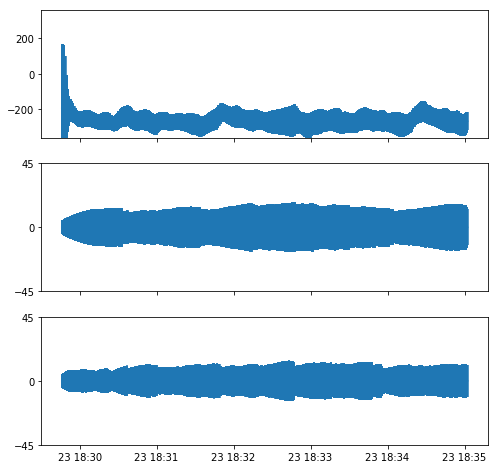

In [3222]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(8,8))
ax1.errorbar(t, *np.degrees([yaw, yawe]))
ax2.errorbar(t, *np.degrees([pitch, pitche]))
ax3.errorbar(t, *np.degrees([roll, rolle]))

ax1.set_ylim([-360, 360])
ax2.set_yticks([-90, -45, 0, 45, 90])
ax2.set_ylim(-45, 45)
ax3.set_yticks([-90, -45, 0, 45, 90])
ax3.set_ylim(-45, 45)

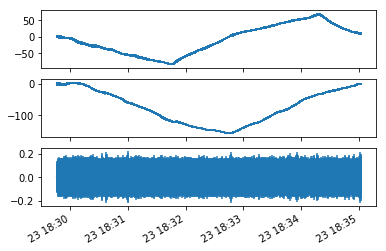

In [3225]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
ax1.errorbar(t, rx, rxe)
ax2.errorbar(t, ry, rye)
ax3.errorbar(t, rz, rze)
fig.autofmt_xdate()

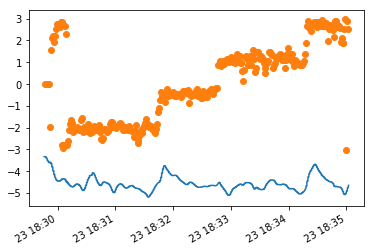

In [3226]:
ddx = np.diff(dx).astype(float)
ddy = np.diff(dy).astype(float)
yaw_gps = np.arctan2(ddy, ddx)

plt.plot(t, yaw)
plt.plot(gps_t[1:], yaw_gps, 'o')
plt.gcf().autofmt_xdate()

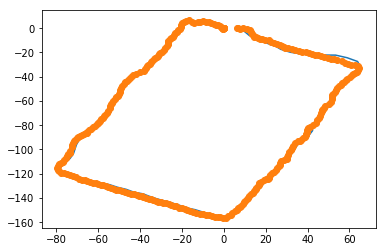

In [3194]:
plt.plot(rx[s], ry[s])
plt.plot(dx, dy, 'o')


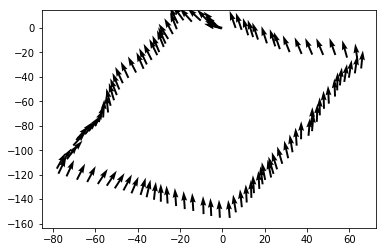

In [3195]:
interval = 60
#s = slice(0, int(len(t)/2), interval)
s = slice(0, -1, interval)
dirx = np.cos(yaw[s])
diry = np.sin(yaw[s])
#plt.plot(rx[::interval], ry[::interval], 'o')
plt.quiver(rx[s], ry[s], dirx, diry)

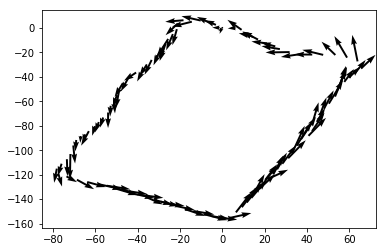

In [3196]:
interval = 50
dirx = np.cos(yaw[s])
diry = np.sin(yaw[s])
#plt.plot(rx[::interval], ry[::interval], 'o')
plt.quiver(rx[s], ry[s], vx[s], vy[s])


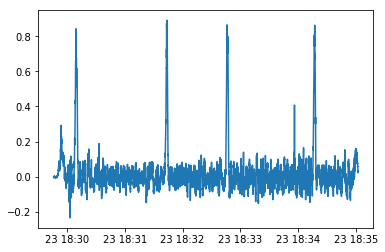

In [3120]:
plt.plot(t, gz)

In [3121]:
np.mean(gy)

0.0063774373414954766

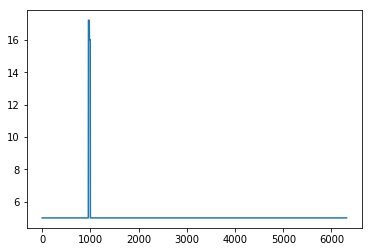

In [3122]:
plt.plot(horizontal_accuracy)

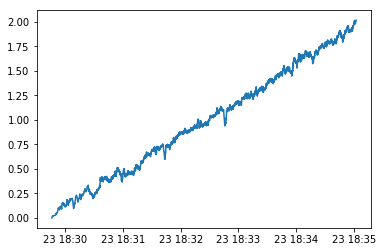

In [3123]:
gyb = 0
heading = np.cumsum(gy - gyb)*dt
plt.plot(t, heading)

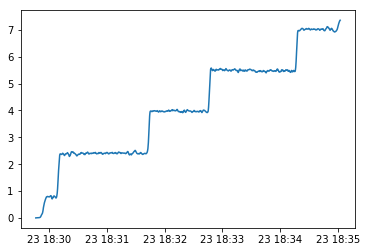

In [3124]:
heading = np.cumsum(gz - gzb)*dt
plt.plot(t, heading)

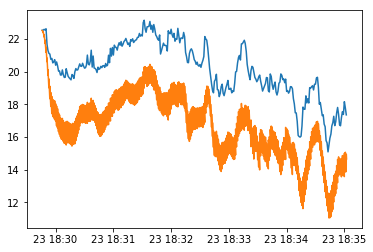

In [3125]:
plt.plot(gps_t, dz)
plt.plot(t, rz)

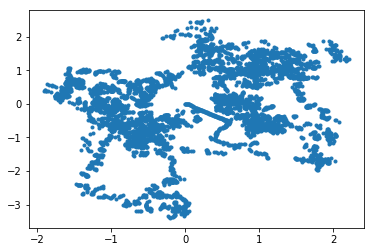

In [3126]:
plt.plot(vx, vy, '.')

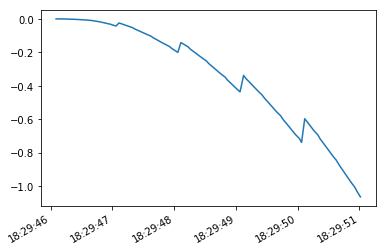

In [3127]:
plt.plot(t[0:100], ry[0:100])
plt.gcf().autofmt_xdate()

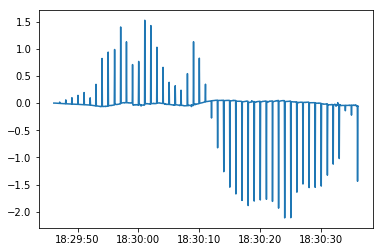

In [3128]:
plt.plot(t[0:1000], np.diff(ry[0:1001]))

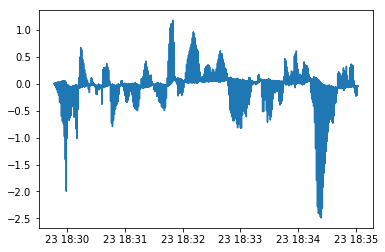

In [3129]:
plt.plot(t[1:], np.diff(rx))

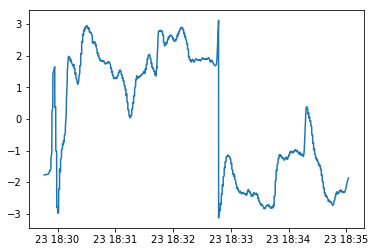

In [3130]:
plt.plot(t, (yaw))

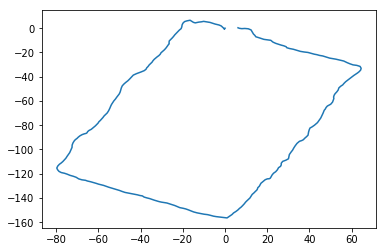

In [3131]:
plt.plot(dx, dy)

<ErrorbarContainer object of 3 artists>

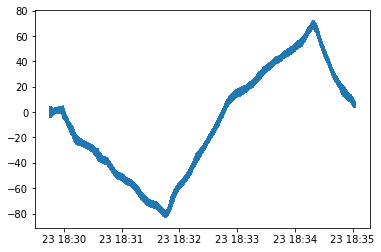

In [3132]:
plt.errorbar(t, rx, rxe)

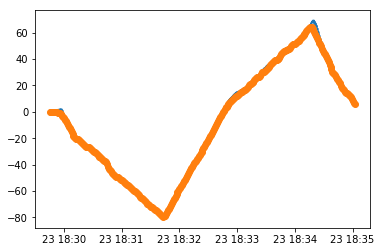

In [3133]:
plt.plot(t, rx)
plt.plot(gps_t, dx, 'o')

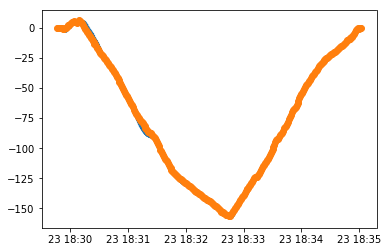

In [3134]:
plt.plot(t, ry)
plt.plot(gps_t, dy, 'o')

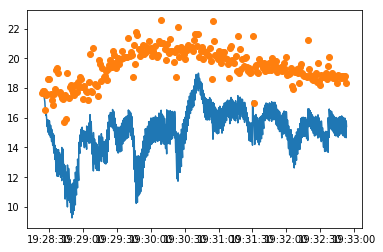

In [3059]:
plt.plot(t, rz)
plt.plot(gps_t, dz, 'o')

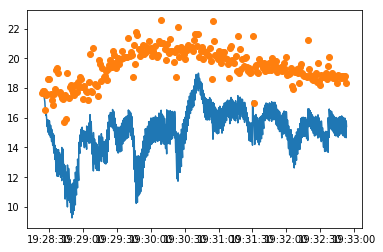

In [3060]:
plt.plot(t, rz)
plt.plot(gps_t, dz, 'o')

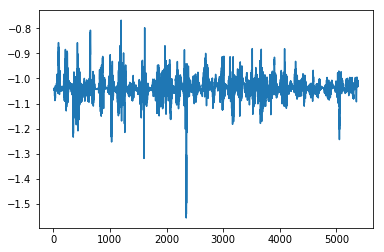

In [3061]:
plt.plot(pd.Series(az - azb).rolling(10).mean())

In [779]:
np.around(h((.5, 0)), 2)

ValueError: not enough values to unpack (expected 3, got 2)

In [780]:
np.around(h((np.pi+.2, 0)), 4)

ValueError: not enough values to unpack (expected 3, got 2)

In [781]:
np.around(h((.2, 0)), 4)

ValueError: not enough values to unpack (expected 3, got 2)

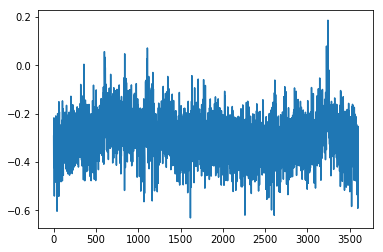

In [782]:
plt.plot(ay)

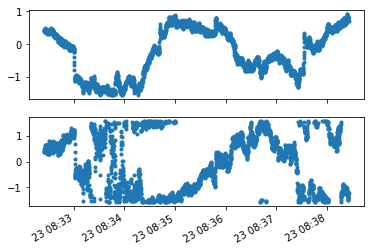

In [787]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)

pitch = kalman_states[:, 0]
roll = kalman_states[:, 1]
ax1.plot(t, pitch, '.')
ax2.plot(t, roll, '.')
fig.autofmt_xdate()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

ax1.plot(inertial_accels[:, 0])
ax2.plot(inertial_accels[:, 1])
ax3.plot(inertial_accels[:,2])
ax1.set_ylim(-3.5, 3.5)
ax2.set_ylim(-3.5, 3.5)
ax3.set_ylim(-3.5, 3.5)

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)

ax1.plot(ax)
ax2.plot(ay)
ax3.plot(az)
ax1.set_ylim(-2.5, 3.5)
ax2.set_ylim(-2.5, 3.5)
ax3.set_ylim(-2.5, 3.5)

In [2018]:
def maybe():
    x = np.random.randn()
    if x > .5:
        return x
    else:
        return

In [2019]:
if a=maybe():
    print(a)

SyntaxError: invalid syntax (<ipython-input-2019-0644318fbf5e>, line 1)